# Time-dependent PDEs
## Types of Time-dependent PDEs that the solver supports
This is a solver for linear (constant/variable coefficient) time-dependent 1D/2D PDEs, i.e., PDEs that can be written in the form of $\mathcal{L}u=f$, where $\mathcal{L}$ is a linear combination of $\{\mathit{I}, \frac{\partial}{\partial t}, \frac{\partial}{\partial x}, \frac{\partial}{\partial y}, \frac{\partial^2}{\partial x^2}, \frac{\partial^2}{\partial y^2}, \dots\}$ whose coefficients __can be either a constant or a function $g(x, y)$__. Additionally, users are free to add any other operators.   
Note: For 1D problems, Crank-Nicolson method is used by default. For 2D problems, the explicit method is applied. This means that users have to apply smaller time steps when they are solving 2D problems, while there is no such constraint for 1D problems.  
  
Before we begin, let's introduce all the environment variables:

In [1]:
%matplotlib inline
import sys, math, numpy as np, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
sys.path.append("../src/")
import fdm.solver.fdm_solver as FDM
import util.diff_operator_expression.diff_op_expression as Expr
from util.diff_operators.impl import ddt, time_dependent_d2dx as d2dx, time_dependent_d2dy as d2dy
from util.domain_conditions.impl.dirichlet import dirichlet_bc as Dirichlet_BC, dirichlet_rectangle as Dirichlet_rectangle
from util.domain_conditions.core.domain import domain as Domain

## 1D Heat Equation Example
Here is the 1D heat equation that we are trying to solve:  
$\pi u_t-u_{xx} = 0$ whose domain is $[0, 1]\times[0, 1]$ with boundary conditions $u(x, 0) = \cos\pi x$, $u(0, t) = e^{-\pi t}$, $u(1, t) = -e^{-\pi t}$.  
Firstly, we define its boundary conditions in our solver.

In [2]:
domain = Domain.domain(np.array([0, 0]), np.array([1, 1]))
inDomain = lambda x, t: 0 < x < 1 and 0 < t < 1
onBoundary = lambda x, t: abs(x-1) < np.spacing(1) or abs(x) < np.spacing(1) or abs(t) < np.spacing(1)
def getBoundaryValue(x, t):
    if abs(x) < np.spacing(1):
        return math.exp(-math.pi*t)
    elif abs(x-1) < np.spacing(1):
        return -math.exp(-math.pi*t)
    else:
        return math.cos(math.pi*x)
boundary_condition = Dirichlet_BC.dirichlet_bc(inDomain, onBoundary, getBoundaryValue, domain) # Boundary condition class

Now we are able to define our solver. Note that we will define the solver on four domains which are discretized in different scales. 

In [3]:
f = lambda x, y: 0 # this is the function on the right hand side of our PDE
approximation = []
for n in [9, 19, 39, 79]:
    dx, dt = 1/(n+1), 1/(n+1)
    expression = Expr.diff_operator_expression([ddt.ddt(dt, coefficient=lambda x, t: math.pi), d2dx.td_d2dx(dx, coefficient=lambda x, y: -1)])
    # Put pi*dt and -d2dx into our expression
    solver = FDM.fdm_solver(expression, f, boundary_condition)
    # Insert the operator expression, function on the right hand side and the boundary condition into our solver
    %timeit -n1 -r1 approximation.append(solver.solve(n, n))
    # n represents grid point numbers. In this case, we have n points in both x and t axis.

43.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
47.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
181 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
691 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It solves this PDE in less than 1 second even when the grid is fine!    
  
You can verify that $u(x, t) = e^{-\pi t}\cos\pi x$ is the analytical solution to this PDE. We now compare our approximation with the analytical solution using the $L^\infty$ norm.

In [4]:
error = [] # Use this array to record the errors of our approximation.
correct_function = lambda x, t: math.exp(-math.pi*t)*math.cos(math.pi*x)

for index, n in enumerate([9, 19, 39, 79]):
    # We get the approximated solution. Then we compare it with the analytical solution.
    correct_solution = np.zeros((n+2)**2)
    for j in range(n+2):
        t = j/(n+1)
        for i in range(n+2):
            x = i/(n+1)
            correct_solution[j*(n+2)+i] = correct_function(x, t)
    error.append(max(abs(approximation[index][1].flatten()-correct_solution)))
print(" n", "   max_error", "err_ratio")
for index, n in enumerate([9, 19, 39, 79]):
    if index == 0: print("{:2d} {:.10f}       NA".format(n, error[index]))
    if index != 0: print("{:2d} {:.10f} {:f}".format(n, error[index], error[index]/error[index-1]))

 n    max_error err_ratio
 9 0.0000075043       NA
19 0.0000004514 0.060155
39 0.0000000282 0.062367
79 0.0000000018 0.062354


Note that Crank-Nicolson method gives us a highly accurate result even when a coarse discretization is applied. And it converges as a fourth-order of accuracy (Theoretically it should be second-order, but I notice that if you double $h_x$ and $h_t$ simutaneously, it will behave like fourth-order. I'm not sure about the reason). Considering the execution time of our solver (less than 1 second when we have $81*81$ grid points), it's reasonable to say that our solver can solve 1D time-dependent PDE both efficiently and accurately.  
  
Here is a plot which portraits the approximation when $n=9$.

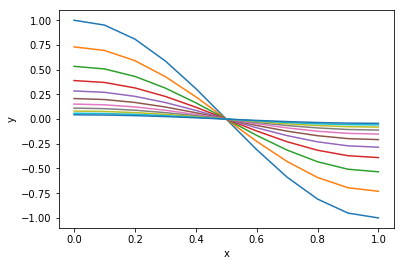

In [5]:
time, result = approximation[0]
for i in range(len(time)):
    plt.plot(np.linspace(0, 1, 11), result[i])
plt.xlabel('x')
plt.ylabel('y');

## 2D Heat Equation Example
Here is the 2D heat equation that we are trying to solve:  
$u_t-u_{xx}-u_{yy} = 0$ whose domain is $\Omega=[0, 1]\times[0, 1]$ with boundary conditions $u(x, y, 0) = 8\sin(\pi x)\sin(\pi y)$, $u(x, y, t) = 0$ for $(x, y)\in \partial \Omega$.  
Firstly, we define its boundary conditions in our solver.

In [6]:
domain = Domain.domain(np.array([0, 0]), np.array([2, 2]))
inDomain = lambda x, y: 0 < x < 2 and 0 < y < 2
onBoundary = lambda x, y: abs(x-2) < np.spacing(1) or abs(x) < np.spacing(1) or abs(y) < np.spacing(1) or abs(y-2) < np.spacing(1)
def getBoundaryValue(x, y):
    return 8*math.sin(math.pi*x)*math.sin(math.pi*y)
simulation_time = 1
boundary_condition = Dirichlet_rectangle.dirichlet_rectangular_bc(inDomain, onBoundary, getBoundaryValue, domain, simulation_time) # Boundary condition class

Now we are able to define our solver. It can be shown that for 2D heat equation in the form $\frac{\partial U}{\partial t} = k\left(\frac{\partial^2U}{\partial x^2} + \frac{\partial^2U}{\partial y^2}\right)$, the maximum time step $\Delta t$ that we can allow without the process becoming unstable is $\Delta t = \frac{1}{2k}\frac{(\Delta x\Delta y)^2}{(\Delta x)^2 + (\Delta y)^2}$. Note that our solver will give a warning if the time step becomes too large. 

In [7]:
f = lambda x, y: 0 # this is the function on the right hand side of our PDE
approximation = []
for n in [9, 19, 39]:
    dx, dy = 2/(n+1), 2/(n+1)
    dt = (dx*dy)**2/(2*(dx**2+dy**2))
    expression = Expr.diff_operator_expression([ddt.ddt(dt), d2dx.td_d2dx(dx, coefficient=lambda x, y: -1), d2dy.td_d2dy(dy, coefficient=lambda x, y: -1)])
    # Put dt, -d2dx and -d2dy into our expression
    solver = FDM.fdm_solver(expression, f, boundary_condition)
    # Insert the operator expression, function on the right hand side and the boundary condition into our solver
    %timeit -n1 -r1 approximation.append(solver.solve(n, n, math.ceil(1/dt)+1))
    # n represents grid point numbers. In this case, we have n points in both x and t axis.

203 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
52.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The explicit method takes a large amount of time compared with Crank-Nicolson method, since we have to decrease the time step size to make our algorithm stable.  
  
You can verify that the solution to this problem is $u(x, y, t) = e^{-2\pi^2t}sin(\pi x)sin(\pi y)$. We now compare our approximation with the analytical solution using the $L^\infty$ norm.

In [8]:
correct_function = lambda x, y, t: 8*math.exp(-2*math.pi**2*t)*math.sin(math.pi*x)*math.sin(math.pi*y)
error = []
for index, n in enumerate([9, 19, 39]):
    # We get the approximated solution. Then we compare it with the analytical solution.
    correct_solution = np.zeros((n+2)**2)
    for j in range(n+2):
        y = 2*j/(n+1)
        for i in range(n+2):
            x = 2*i/(n+1)
            correct_solution[j*(n+2)+i] = correct_function(x, y, 1)
    error.append(max(abs(approximation[index][1][-1].flatten()-correct_solution)))
print(" n", "       max_error", "err_ratio")
for index, n in enumerate([9, 19, 39]):
    if index == 0: print("{:2d} {:.14f}       NA".format(n, error[index]))
    if index != 0: print("{:2d} {:.14f} {:f}".format(n, error[index], error[index]/error[index-1]))

 n        max_error err_ratio
 9 0.00000001639931       NA
19 0.00000000753370 0.459391
39 0.00000000216195 0.286970


As $n$ gets larger, we can see that it converges as a second-order of accuracy.  

Here is a plot which portraits the approximation when $n=39$. 

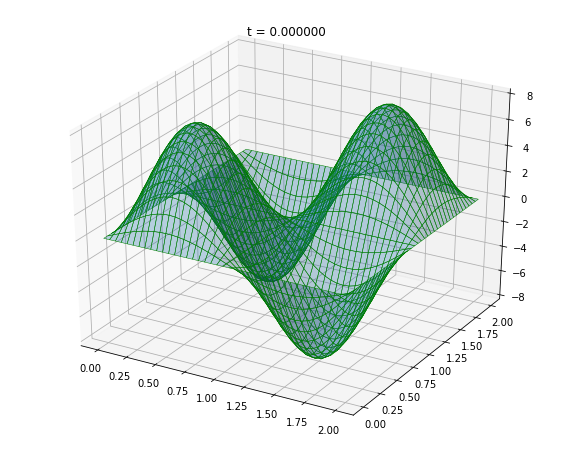

In [9]:
x, y = np.linspace(0, 2, 41), np.linspace(0, 2, 41)
xx, yy = np.meshgrid(x, y)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8)); ax = fig.add_subplot(1, 1, 1, projection='3d'); ax.set_zlim(-8, 8)
ax.plot_surface(xx, yy, approximation[-1][1][0], alpha=0.3, linewidth=0.5, edgecolors='g')
plt.title('t = {:4f}'.format(approximation[-1][0][0])); 

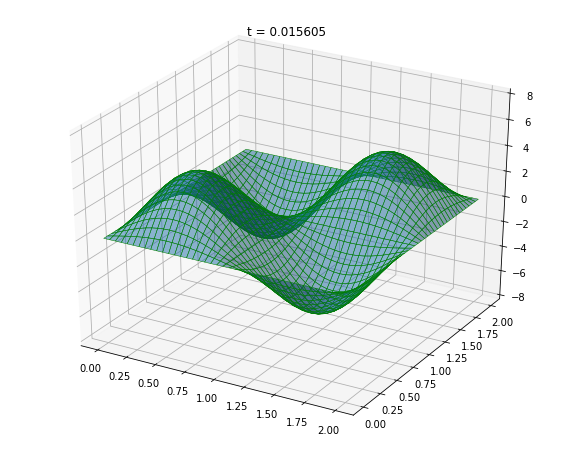

In [10]:
fig = plt.figure(figsize=(10, 8)); ax = fig.add_subplot(1, 1, 1, projection='3d'); ax.set_zlim(-8, 8)
ax.plot_surface(xx, yy, approximation[-1][1][50], alpha=0.5, linewidth=0.5, edgecolors='g')
plt.title('t = {:4f}'.format(approximation[-1][0][25])); 

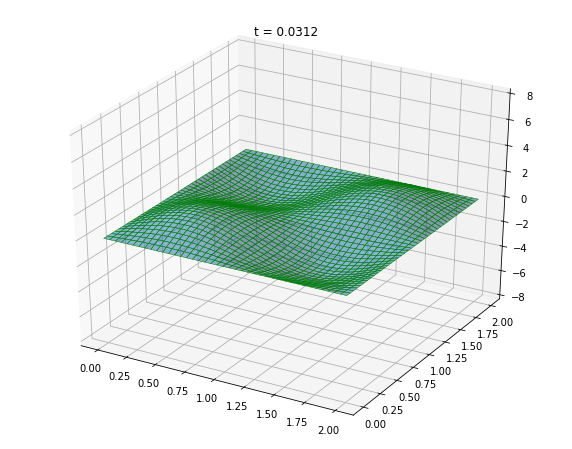

In [11]:
fig = plt.figure(figsize=(10, 8)); ax = fig.add_subplot(1, 1, 1, projection='3d'); ax.set_zlim(-8, 8)
ax.plot_surface(xx, yy, approximation[-1][1][150], alpha=0.5, linewidth=0.5, edgecolors='g')
plt.title('t = {:.4f}'.format(approximation[-1][0][50])); 

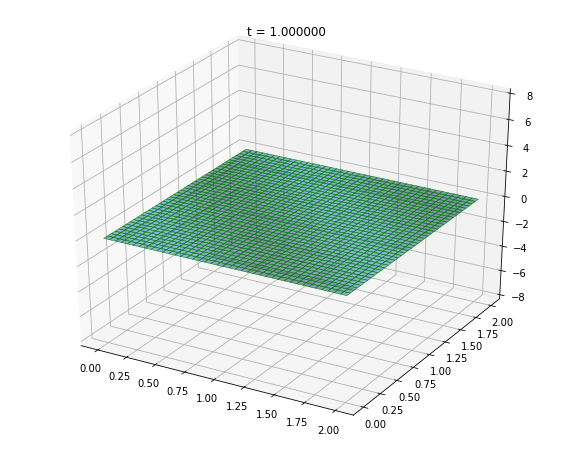

In [12]:
fig = plt.figure(figsize=(10, 8)); ax = fig.add_subplot(1, 1, 1, projection='3d'); ax.set_zlim(-8, 8)
ax.plot_surface(xx, yy, approximation[-1][1][-1], alpha=0.5, linewidth=0.5, edgecolors='g')
plt.title('t = {:4f}'.format(approximation[-1][0][-1])); 

We can see that our approximation perfectly resembles the diffusion of heat.